In [1]:
!wandb login 55d09ffedb7a5b9c08dfddc17d834220dbf0bfa4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/katrindar/.netrc


In [2]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


In [3]:
# Initialize W&B project (done once)
wandb.init(project="wildfire-prediction-experiments")
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: katrinpochtar. Use `wandb login --relogin` to force relogin


In [4]:
def display_random_sample(dataset_dir):
    classes = [
        class_name for class_name in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, class_name))
    ]
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_dir)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        if not image_files:
            continue

        random_image = random.choice(image_files)
        img_path = os.path.join(class_dir, random_image)
        img = load_img(img_path)
        
        plt.subplot(1, len(classes), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} ({img.size[0]}x{img.size[1]})")
    plt.show()


Training set samples:


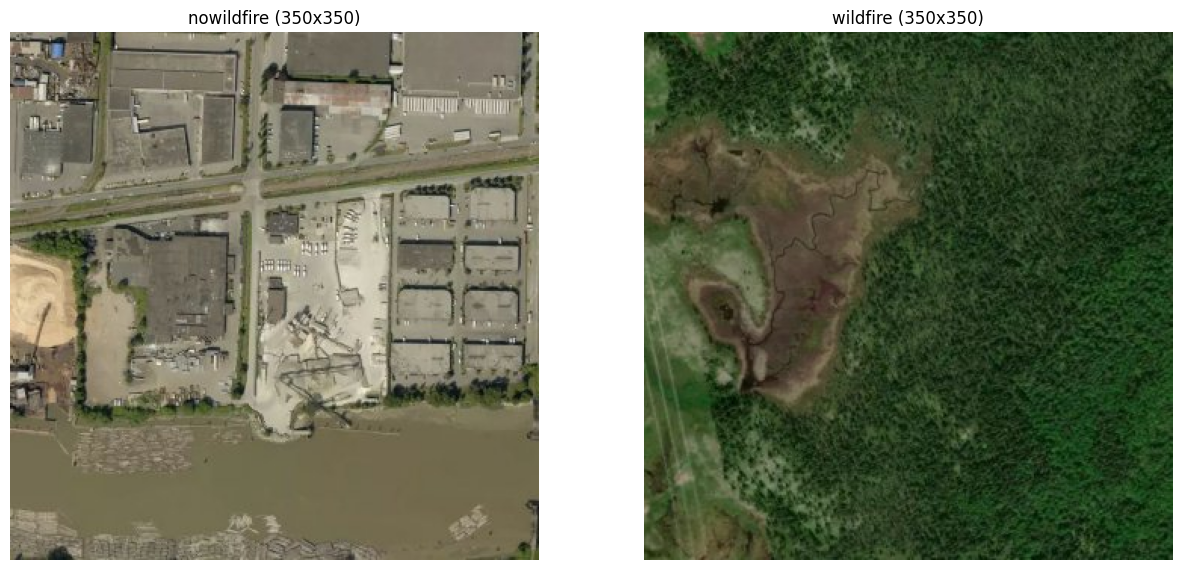

Validation set samples:


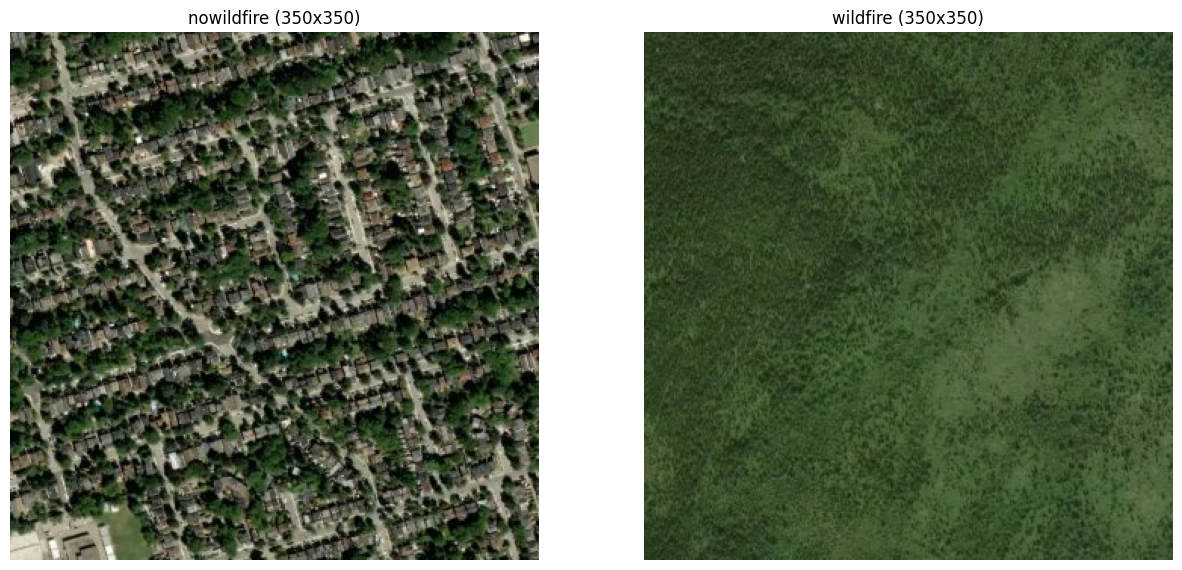

Test set samples:


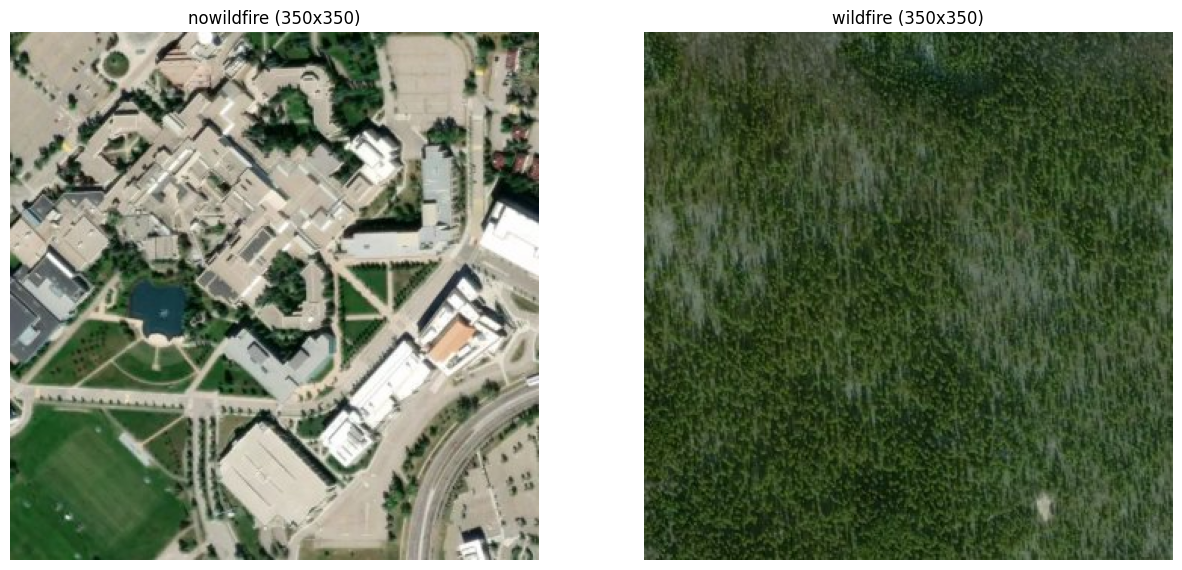

In [5]:
train_dir = 'fire_data/train'
valid_dir = 'fire_data/valid'
test_dir = 'fire_data/test'

print("Training set samples:")
display_random_sample(train_dir)

print("Validation set samples:")
display_random_sample(valid_dir)

print("Test set samples:")
display_random_sample(test_dir)

In [6]:
def load_data(directory, img_size=(32, 32)):
    X, Y = [], []
    for direct in os.listdir(directory):
        direct_path = os.path.join(directory, direct)
        if not os.path.isdir(direct_path):
            continue
        for filename in os.listdir(direct_path):
            img_path = os.path.join(direct_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            Y.append(direct)
    return np.array(X), np.array(Y)

x_train, y_train = load_data(train_dir)
x_val, y_val = load_data(valid_dir)
x_test, y_test = load_data(test_dir)

# Convert labels to binary
y_train = np.array([1 if label == 'wildfire' else 0 for label in y_train])
y_val = np.array([1 if label == 'wildfire' else 0 for label in y_val])
y_test = np.array([1 if label == 'wildfire' else 0 for label in y_test])

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

Premature end of JPEG file
Premature end of JPEG file


x_train shape: (30250, 32, 32, 3)
x_val shape: (6300, 32, 32, 3)
x_test shape: (6300, 32, 32, 3)
y_train shape: (30250,)
y_val shape: (6300,)
y_test shape: (6300,)


In [7]:
def build_model(input_shape, conv_layers, conv_filters, dense_units, dropout_rate, activation, optimizer, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    for i in range(conv_layers):
        model.add(Conv2D(conv_filters[i], (3, 3), padding='same', activation=activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not recognized")

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
# Define hyperparameter grids to generate ~150 experiments
conv_layer_options = [1, 2]                     # 2 options
dense_units_options = [64, 128, 256]            # 3 options
dropout_options = [0.2, 0.3]                    # 2 options
learning_rates = [0.001, 0.0001]                # 2 options
optimizers = ['adam', 'sgd']                    # 2 options (reduced from 3 to control experiment count)
epochs_options = [10, 20, 30]                   # 3 options

experiment_configs = []

for conv_layers in conv_layer_options:
    for dense_units in dense_units_options:
        for dropout_rate in dropout_options:
            for lr in learning_rates:
                for optimizer in optimizers:
                    for ep in epochs_options:
                        exp = {
                            "conv_layers": conv_layers,
                            "conv_filters": [32]*conv_layers,  # Keep filter sizes uniform for simplicity
                            "dense_units": dense_units,
                            "dropout_rate": dropout_rate,
                            "activation": "relu",
                            "optimizer": optimizer,
                            "learning_rate": lr,
                            "batch_size": 32,
                            "epochs": ep
                        }
                        experiment_configs.append(exp)

print(f"Number of experiments: {len(experiment_configs)}")

Number of experiments: 144


In [9]:
# Run the experiments
for i, config in enumerate(experiment_configs):
    print(f"Starting experiment {i+1}/{len(experiment_configs)} with config: {config}")
    wandb.init(project="wildfire-prediction-experiments", config=config, reinit=True)
    
    model = build_model(
        input_shape=(32,32,3),
        conv_layers=config["conv_layers"],
        conv_filters=config["conv_filters"],
        dense_units=config["dense_units"],
        dropout_rate=config["dropout_rate"],
        activation=config["activation"],
        optimizer=config["optimizer"],
        learning_rate=config["learning_rate"]
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=config["batch_size"],
        epochs=config["epochs"],
        callbacks=[
            WandbMetricsLogger(),
            WandbModelCheckpoint(filepath="model.keras"),
            early_stopping
        ],
        verbose=1
    )
    
    # Evaluate on test data
    test_predictions = model.predict(x_test)
    y_pred = (test_predictions > 0.5).astype("int32").ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')

    wandb.log({
        "test_accuracy": accuracy,
        "test_precision": precision,
        "test_recall": recall
    })

    wandb.finish()

Starting experiment 1/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9002 - loss: 0.2872 - val_accuracy: 0.9394 - val_loss: 0.1664
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9351 - loss: 0.1709 - val_accuracy: 0.9352 - val_loss: 0.1825
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9410 - loss: 0.1514 - val_accuracy: 0.9290 - val_loss: 0.1877
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9519 - loss: 0.1232 - val_accuracy: 0.9457 - val_loss: 0.1449
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9588 - loss: 0.1109 - val_accuracy: 0.9444 - val_loss: 0.1572
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9661 - loss: 0.0915 - val_accuracy: 0.9429 - val_loss: 0.1579
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9712 - loss: 0.0776 - val_accuracy: 0.8398 - val_loss: 0.5383
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9706 - loss: 0.0791 - val

Starting experiment 2/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9032 - loss: 0.2866 - val_accuracy: 0.9417 - val_loss: 0.1716
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9363 - loss: 0.1661 - val_accuracy: 0.9465 - val_loss: 0.1519
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9445 - loss: 0.1426 - val_accuracy: 0.9414 - val_loss: 0.1590
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9559 - loss: 0.1183 - val_accuracy: 0.9494 - val_loss: 0.1467
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9615 - loss: 0.1029 - val_accuracy: 0.9179 - val_loss: 0.2421
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9697 - loss: 0.0843 - val_accuracy: 0.9490 - val_loss: 0.1436
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9724 - loss: 0.0770 - val_accuracy: 0.9379 - val_loss: 0.1859
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9731 - loss: 0.0763 - val

Starting experiment 3/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9035 - loss: 0.3036 - val_accuracy: 0.9417 - val_loss: 0.1515
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9350 - loss: 0.1669 - val_accuracy: 0.9302 - val_loss: 0.1786
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9492 - loss: 0.1373 - val_accuracy: 0.9443 - val_loss: 0.1454
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9550 - loss: 0.1231 - val_accuracy: 0.9321 - val_loss: 0.1916
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9577 - loss: 0.1106 - val_accuracy: 0.9430 - val_loss: 0.1761
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9643 - loss: 0.0953 - val_accuracy: 0.9468 - val_loss: 0.1791
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9671 - loss: 0.0863 - val_accuracy: 0.9321 - val_loss: 0.2078
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 4/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8778 - loss: 0.3289 - val_accuracy: 0.9230 - val_loss: 0.2108
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9064 - loss: 0.2433 - val_accuracy: 0.9287 - val_loss: 0.1914
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9181 - loss: 0.2171 - val_accuracy: 0.9302 - val_loss: 0.1885
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9173 - loss: 0.2164 - val_accuracy: 0.9368 - val_loss: 0.1699
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9208 - loss: 0.2044 - val_accuracy: 0.9408 - val_loss: 0.1631
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9254 - loss: 0.1945 - val_accuracy: 0.9414 - val_loss: 0.1586
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9259 - loss: 0.1906 - val_accuracy: 0.9410 - val_loss: 0.1549
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9294 - loss: 0.1843 - val_accuracy: 0.

Starting experiment 5/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8778 - loss: 0.3111 - val_accuracy: 0.9267 - val_loss: 0.1947
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9096 - loss: 0.2318 - val_accuracy: 0.9305 - val_loss: 0.1847
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9183 - loss: 0.2137 - val_accuracy: 0.9337 - val_loss: 0.1767
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9186 - loss: 0.2102 - val_accuracy: 0.9332 - val_loss: 0.1750
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9201 - loss: 0.2048 - val_accuracy: 0.9337 - val_loss: 0.1701
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9259 - loss: 0.1973 - val_accuracy: 0.9340 - val_loss: 0.1700
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9245 - loss: 0.1929 - val_accuracy: 0.9367 - val_loss: 0.1624
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9274 - loss: 0.1919 - val_accuracy: 0.

Starting experiment 6/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8801 - loss: 0.3075 - val_accuracy: 0.9244 - val_loss: 0.2016
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9095 - loss: 0.2388 - val_accuracy: 0.9278 - val_loss: 0.1886
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9117 - loss: 0.2329 - val_accuracy: 0.9303 - val_loss: 0.1800
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9196 - loss: 0.2098 - val_accuracy: 0.9317 - val_loss: 0.1730
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9212 - loss: 0.2050 - val_accuracy: 0.9362 - val_loss: 0.1662
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9229 - loss: 0.2025 - val_accuracy: 0.9344 - val_loss: 0.1637
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9250 - loss: 0.1964 - val_accuracy: 0.9356 - val_loss: 0.1675
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9297 - loss: 0.1842 - val_accuracy: 0.

Starting experiment 7/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9003 - loss: 0.2578 - val_accuracy: 0.9394 - val_loss: 0.1624
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9352 - loss: 0.1704 - val_accuracy: 0.9456 - val_loss: 0.1432
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9478 - loss: 0.1365 - val_accuracy: 0.9478 - val_loss: 0.1330
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9564 - loss: 0.1161 - val_accuracy: 0.9511 - val_loss: 0.1345
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9615 - loss: 0.1046 - val_accuracy: 0.9467 - val_loss: 0.1361
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9668 - loss: 0.0912 - val_accuracy: 0.9494 - val_loss: 0.1464
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9721 - loss: 0.0801 - val_accuracy: 0.9498 - val_loss: 0.1408
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 8/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9070 - loss: 0.2600 - val_accuracy: 0.9376 - val_loss: 0.1626
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9290 - loss: 0.1811 - val_accuracy: 0.9433 - val_loss: 0.1439
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9441 - loss: 0.1493 - val_accuracy: 0.9411 - val_loss: 0.1530
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9525 - loss: 0.1269 - val_accuracy: 0.9460 - val_loss: 0.1398
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9604 - loss: 0.1081 - val_accuracy: 0.9483 - val_loss: 0.1407
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9683 - loss: 0.0917 - val_accuracy: 0.9490 - val_loss: 0.1349
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9708 - loss: 0.0820 - val_accuracy: 0.9498 - val_loss: 0.1423
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9746 - loss: 0.0724 - val_

Starting experiment 9/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8982 - loss: 0.2684 - val_accuracy: 0.9406 - val_loss: 0.1546
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9311 - loss: 0.1786 - val_accuracy: 0.9457 - val_loss: 0.1384
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9438 - loss: 0.1466 - val_accuracy: 0.9481 - val_loss: 0.1386
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9533 - loss: 0.1242 - val_accuracy: 0.9492 - val_loss: 0.1350
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9634 - loss: 0.1048 - val_accuracy: 0.9484 - val_loss: 0.1374
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9667 - loss: 0.0921 - val_accuracy: 0.9402 - val_loss: 0.1682
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9700 - loss: 0.0821 - val_accuracy: 0.9486 - val_loss: 0.1371
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9750 - loss: 0.0705 - val_accur

Starting experiment 10/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8207 - loss: 0.4035 - val_accuracy: 0.9051 - val_loss: 0.2673
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8861 - loss: 0.2970 - val_accuracy: 0.9097 - val_loss: 0.2424
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8923 - loss: 0.2805 - val_accuracy: 0.9151 - val_loss: 0.2288
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8953 - loss: 0.2715 - val_accuracy: 0.9205 - val_loss: 0.2212
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8984 - loss: 0.2642 - val_accuracy: 0.9227 - val_loss: 0.2154
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9038 - loss: 0.2555 - val_accuracy: 0.9241 - val_loss: 0.2111
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9034 - loss: 0.2557 - val_accuracy: 0.9254 - val_loss: 0.2072
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9044 - loss: 0.2530 - val_accuracy: 

Starting experiment 11/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8030 - loss: 0.4555 - val_accuracy: 0.9067 - val_loss: 0.2832
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8860 - loss: 0.3076 - val_accuracy: 0.9114 - val_loss: 0.2572
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8912 - loss: 0.2847 - val_accuracy: 0.9133 - val_loss: 0.2393
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8978 - loss: 0.2667 - val_accuracy: 0.9176 - val_loss: 0.2295
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8989 - loss: 0.2599 - val_accuracy: 0.9216 - val_loss: 0.2218
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9026 - loss: 0.2502 - val_accuracy: 0.9254 - val_loss: 0.2143
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9056 - loss: 0.2486 - val_accuracy: 0.9252 - val_loss: 0.2093
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9094 - loss: 0.2380 - val_accuracy: 0.

Starting experiment 12/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8427 - loss: 0.3933 - val_accuracy: 0.9005 - val_loss: 0.2684
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8840 - loss: 0.2965 - val_accuracy: 0.9062 - val_loss: 0.2370
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8895 - loss: 0.2756 - val_accuracy: 0.9137 - val_loss: 0.2221
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8963 - loss: 0.2636 - val_accuracy: 0.9171 - val_loss: 0.2133
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8995 - loss: 0.2574 - val_accuracy: 0.9200 - val_loss: 0.2073
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9049 - loss: 0.2479 - val_accuracy: 0.9205 - val_loss: 0.2039
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9043 - loss: 0.2459 - val_accuracy: 0.9210 - val_loss: 0.2002
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9064 - loss: 0.2460 - val_accuracy: 0.

Starting experiment 13/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9051 - loss: 0.2686 - val_accuracy: 0.9419 - val_loss: 0.1509
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9377 - loss: 0.1651 - val_accuracy: 0.9303 - val_loss: 0.1984
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9469 - loss: 0.1397 - val_accuracy: 0.9429 - val_loss: 0.1504
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9545 - loss: 0.1261 - val_accuracy: 0.9411 - val_loss: 0.1483
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9609 - loss: 0.1074 - val_accuracy: 0.9379 - val_loss: 0.1754
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9638 - loss: 0.0968 - val_accuracy: 0.9270 - val_loss: 0.2431
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9670 - loss: 0.0897 - val_accuracy: 0.9383 - val_loss: 0.1883
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9710 - loss: 0.0815 - val_accurac

Starting experiment 14/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9053 - loss: 0.3059 - val_accuracy: 0.9425 - val_loss: 0.1537
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9344 - loss: 0.1700 - val_accuracy: 0.9454 - val_loss: 0.1454
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9443 - loss: 0.1441 - val_accuracy: 0.9371 - val_loss: 0.1752
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9473 - loss: 0.1357 - val_accuracy: 0.9148 - val_loss: 0.2503
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9569 - loss: 0.1162 - val_accuracy: 0.9410 - val_loss: 0.1758
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9612 - loss: 0.1060 - val_accuracy: 0.9387 - val_loss: 0.1745
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 15/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9029 - loss: 0.3103 - val_accuracy: 0.9151 - val_loss: 0.2131
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9318 - loss: 0.1786 - val_accuracy: 0.9454 - val_loss: 0.1464
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9433 - loss: 0.1463 - val_accuracy: 0.9271 - val_loss: 0.2007
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9494 - loss: 0.1343 - val_accuracy: 0.9511 - val_loss: 0.1279
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9574 - loss: 0.1150 - val_accuracy: 0.9422 - val_loss: 0.1452
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9615 - loss: 0.1055 - val_accuracy: 0.9303 - val_loss: 0.1837
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9629 - loss: 0.0984 - val_accuracy: 0.9417 - val_loss: 0.1684
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9675 - loss: 0.0890 - val_ac

Starting experiment 16/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8713 - loss: 0.3179 - val_accuracy: 0.9260 - val_loss: 0.2070
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9077 - loss: 0.2466 - val_accuracy: 0.9278 - val_loss: 0.1929
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9098 - loss: 0.2325 - val_accuracy: 0.9290 - val_loss: 0.1799
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9132 - loss: 0.2231 - val_accuracy: 0.9313 - val_loss: 0.1757
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9192 - loss: 0.2080 - val_accuracy: 0.9333 - val_loss: 0.1758
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9186 - loss: 0.2106 - val_accuracy: 0.9332 - val_loss: 0.1672
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9209 - loss: 0.2038 - val_accuracy: 0.9352 - val_loss: 0.1644
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9222 - loss: 0.1988 - val_accuracy: 0.

Starting experiment 17/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8779 - loss: 0.3198 - val_accuracy: 0.9152 - val_loss: 0.2169
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9091 - loss: 0.2425 - val_accuracy: 0.9286 - val_loss: 0.1852
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9100 - loss: 0.2339 - val_accuracy: 0.9344 - val_loss: 0.1732
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9173 - loss: 0.2121 - val_accuracy: 0.9367 - val_loss: 0.1697
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9210 - loss: 0.2078 - val_accuracy: 0.9371 - val_loss: 0.1646
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9259 - loss: 0.1945 - val_accuracy: 0.9376 - val_loss: 0.1685
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9253 - loss: 0.1952 - val_accuracy: 0.9410 - val_loss: 0.1544
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9256 - loss: 0.1912 - val_accuracy: 

Starting experiment 18/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8677 - loss: 0.3355 - val_accuracy: 0.9232 - val_loss: 0.2073
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9056 - loss: 0.2483 - val_accuracy: 0.9262 - val_loss: 0.1915
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9088 - loss: 0.2384 - val_accuracy: 0.9303 - val_loss: 0.1780
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9121 - loss: 0.2247 - val_accuracy: 0.9335 - val_loss: 0.1712
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9153 - loss: 0.2215 - val_accuracy: 0.9349 - val_loss: 0.1681
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9204 - loss: 0.2077 - val_accuracy: 0.9381 - val_loss: 0.1631
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9189 - loss: 0.2052 - val_accuracy: 0.9381 - val_loss: 0.1585
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9233 - loss: 0.1952 - val_accuracy: 0.

Starting experiment 19/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8909 - loss: 0.2905 - val_accuracy: 0.9359 - val_loss: 0.1654
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9353 - loss: 0.1763 - val_accuracy: 0.9435 - val_loss: 0.1505
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9428 - loss: 0.1527 - val_accuracy: 0.9349 - val_loss: 0.1698
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9493 - loss: 0.1363 - val_accuracy: 0.9449 - val_loss: 0.1444
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9527 - loss: 0.1239 - val_accuracy: 0.9389 - val_loss: 0.1550
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9588 - loss: 0.1115 - val_accuracy: 0.9500 - val_loss: 0.1390
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9650 - loss: 0.1007 - val_accuracy: 0.9454 - val_loss: 0.1464
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9683 - loss: 0.0910 - va

Starting experiment 20/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9003 - loss: 0.2748 - val_accuracy: 0.9422 - val_loss: 0.1588
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9304 - loss: 0.1835 - val_accuracy: 0.9429 - val_loss: 0.1513
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9421 - loss: 0.1532 - val_accuracy: 0.9438 - val_loss: 0.1470
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9507 - loss: 0.1342 - val_accuracy: 0.9460 - val_loss: 0.1402
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9594 - loss: 0.1123 - val_accuracy: 0.9498 - val_loss: 0.1342
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9581 - loss: 0.1118 - val_accuracy: 0.9459 - val_loss: 0.1427
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9647 - loss: 0.0961 - val_accuracy: 0.9490 - val_loss: 0.1425
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9701 - loss: 0.0833 - val_acc

Starting experiment 21/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8985 - loss: 0.2715 - val_accuracy: 0.9384 - val_loss: 0.1641
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9293 - loss: 0.1875 - val_accuracy: 0.9427 - val_loss: 0.1488
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9442 - loss: 0.1512 - val_accuracy: 0.9462 - val_loss: 0.1409
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9520 - loss: 0.1287 - val_accuracy: 0.9476 - val_loss: 0.1354
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9576 - loss: 0.1169 - val_accuracy: 0.9440 - val_loss: 0.1529
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9649 - loss: 0.0988 - val_accuracy: 0.9510 - val_loss: 0.1385
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9679 - loss: 0.0881 - val_accuracy: 0.9483 - val_loss: 0.1378
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9693 - loss: 0.0834 - val_accu

Starting experiment 22/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7966 - loss: 0.4662 - val_accuracy: 0.9022 - val_loss: 0.2836
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8847 - loss: 0.3121 - val_accuracy: 0.9078 - val_loss: 0.2619
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8867 - loss: 0.3028 - val_accuracy: 0.9106 - val_loss: 0.2477
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8901 - loss: 0.2857 - val_accuracy: 0.9129 - val_loss: 0.2376
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8911 - loss: 0.2774 - val_accuracy: 0.9132 - val_loss: 0.2305
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8925 - loss: 0.2747 - val_accuracy: 0.9149 - val_loss: 0.2261
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8990 - loss: 0.2588 - val_accuracy: 0.9183 - val_loss: 0.2205
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9004 - loss: 0.2596 - val_accuracy: 0.

Starting experiment 23/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7563 - loss: 0.4879 - val_accuracy: 0.9038 - val_loss: 0.2981
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8816 - loss: 0.3274 - val_accuracy: 0.9075 - val_loss: 0.2727
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8833 - loss: 0.3118 - val_accuracy: 0.9086 - val_loss: 0.2552
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8882 - loss: 0.2985 - val_accuracy: 0.9098 - val_loss: 0.2423
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8895 - loss: 0.2853 - val_accuracy: 0.9102 - val_loss: 0.2316
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8886 - loss: 0.2817 - val_accuracy: 0.9122 - val_loss: 0.2245
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8958 - loss: 0.2670 - val_accuracy: 0.9137 - val_loss: 0.2182
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8954 - loss: 0.2654 - val_accuracy: 0.

Starting experiment 24/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8112 - loss: 0.4504 - val_accuracy: 0.9070 - val_loss: 0.2803
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8853 - loss: 0.3130 - val_accuracy: 0.9102 - val_loss: 0.2588
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8935 - loss: 0.2853 - val_accuracy: 0.9111 - val_loss: 0.2478
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8942 - loss: 0.2745 - val_accuracy: 0.9130 - val_loss: 0.2393
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8966 - loss: 0.2655 - val_accuracy: 0.9157 - val_loss: 0.2312
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8958 - loss: 0.2642 - val_accuracy: 0.9178 - val_loss: 0.2249
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9005 - loss: 0.2549 - val_accuracy: 0.9186 - val_loss: 0.2212
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9015 - loss: 0.2553 - val_accuracy: 0.

Starting experiment 25/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9035 - loss: 0.3396 - val_accuracy: 0.9302 - val_loss: 0.1848
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9355 - loss: 0.1698 - val_accuracy: 0.9157 - val_loss: 0.2364
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9447 - loss: 0.1440 - val_accuracy: 0.9457 - val_loss: 0.1491
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9547 - loss: 0.1233 - val_accuracy: 0.9127 - val_loss: 0.2650
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9574 - loss: 0.1117 - val_accuracy: 0.9443 - val_loss: 0.1658
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9668 - loss: 0.0925 - val_accuracy: 0.9421 - val_loss: 0.1666
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9682 - loss: 0.0879 - val_accuracy: 0.9397 - val_loss: 0.2078
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 26/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9015 - loss: 0.3254 - val_accuracy: 0.9132 - val_loss: 0.2054
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9331 - loss: 0.1728 - val_accuracy: 0.9462 - val_loss: 0.1480
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9440 - loss: 0.1511 - val_accuracy: 0.9456 - val_loss: 0.1505
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9521 - loss: 0.1267 - val_accuracy: 0.9432 - val_loss: 0.1582
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9575 - loss: 0.1081 - val_accuracy: 0.9359 - val_loss: 0.1886
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9654 - loss: 0.0937 - val_accuracy: 0.9446 - val_loss: 0.1645
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 27/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9009 - loss: 0.3060 - val_accuracy: 0.9392 - val_loss: 0.1698
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9365 - loss: 0.1683 - val_accuracy: 0.9176 - val_loss: 0.2190
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9491 - loss: 0.1367 - val_accuracy: 0.9357 - val_loss: 0.1972
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9543 - loss: 0.1188 - val_accuracy: 0.9446 - val_loss: 0.1587
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9570 - loss: 0.1107 - val_accuracy: 0.9414 - val_loss: 0.1962
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9654 - loss: 0.0940 - val_accuracy: 0.9440 - val_loss: 0.1693
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9687 - loss: 0.0848 - val_accuracy: 0.9433 - val_loss: 0.1592
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9769 - loss: 0.0691 - 

Starting experiment 28/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8764 - loss: 0.3105 - val_accuracy: 0.9235 - val_loss: 0.2125
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9100 - loss: 0.2366 - val_accuracy: 0.9263 - val_loss: 0.1943
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9138 - loss: 0.2272 - val_accuracy: 0.9335 - val_loss: 0.1843
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9176 - loss: 0.2207 - val_accuracy: 0.9346 - val_loss: 0.1771
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9180 - loss: 0.2055 - val_accuracy: 0.9368 - val_loss: 0.1707
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9219 - loss: 0.1970 - val_accuracy: 0.9290 - val_loss: 0.1874
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9284 - loss: 0.1897 - val_accuracy: 0.9392 - val_loss: 0.1668
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9266 - loss: 0.1937 - val_accuracy: 0.

Starting experiment 29/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8706 - loss: 0.3310 - val_accuracy: 0.9233 - val_loss: 0.2057
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9102 - loss: 0.2308 - val_accuracy: 0.9244 - val_loss: 0.1899
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9130 - loss: 0.2208 - val_accuracy: 0.9278 - val_loss: 0.1808
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9172 - loss: 0.2143 - val_accuracy: 0.9310 - val_loss: 0.1762
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9223 - loss: 0.2039 - val_accuracy: 0.9354 - val_loss: 0.1711
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9211 - loss: 0.2012 - val_accuracy: 0.9346 - val_loss: 0.1696
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9269 - loss: 0.1943 - val_accuracy: 0.9368 - val_loss: 0.1632
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9257 - loss: 0.1891 - val_accuracy: 0.

Starting experiment 30/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8778 - loss: 0.3206 - val_accuracy: 0.9210 - val_loss: 0.2064
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9058 - loss: 0.2441 - val_accuracy: 0.9311 - val_loss: 0.1871
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9118 - loss: 0.2290 - val_accuracy: 0.9341 - val_loss: 0.1781
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9207 - loss: 0.2109 - val_accuracy: 0.9365 - val_loss: 0.1707
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9213 - loss: 0.2028 - val_accuracy: 0.9375 - val_loss: 0.1679
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9236 - loss: 0.1956 - val_accuracy: 0.9406 - val_loss: 0.1586
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9254 - loss: 0.1905 - val_accuracy: 0.9402 - val_loss: 0.1596
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9271 - loss: 0.1859 - val_accuracy

Starting experiment 31/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9029 - loss: 0.2610 - val_accuracy: 0.9378 - val_loss: 0.1550
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9374 - loss: 0.1653 - val_accuracy: 0.9425 - val_loss: 0.1496
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9514 - loss: 0.1340 - val_accuracy: 0.9467 - val_loss: 0.1390
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9585 - loss: 0.1108 - val_accuracy: 0.9441 - val_loss: 0.1421
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9659 - loss: 0.0930 - val_accuracy: 0.9440 - val_loss: 0.1421
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9747 - loss: 0.0753 - val_accuracy: 0.9430 - val_loss: 0.1643
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9750 - loss: 0.0691 - val_accuracy: 0.9462 - val_loss: 0.1660
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 32/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8996 - loss: 0.2679 - val_accuracy: 0.9405 - val_loss: 0.1595
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9341 - loss: 0.1710 - val_accuracy: 0.9411 - val_loss: 0.1522
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9502 - loss: 0.1324 - val_accuracy: 0.9460 - val_loss: 0.1383
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9566 - loss: 0.1145 - val_accuracy: 0.9468 - val_loss: 0.1432
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9667 - loss: 0.0933 - val_accuracy: 0.9454 - val_loss: 0.1540
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9694 - loss: 0.0876 - val_accuracy: 0.9387 - val_loss: 0.1869
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9773 - loss: 0.0657 - val_accuracy: 0.9492 - val_loss: 0.1482
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 33/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8982 - loss: 0.2790 - val_accuracy: 0.9414 - val_loss: 0.1658
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9377 - loss: 0.1658 - val_accuracy: 0.9360 - val_loss: 0.1617
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9472 - loss: 0.1374 - val_accuracy: 0.9468 - val_loss: 0.1450
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9598 - loss: 0.1109 - val_accuracy: 0.9437 - val_loss: 0.1470
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9669 - loss: 0.0946 - val_accuracy: 0.9494 - val_loss: 0.1369
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9703 - loss: 0.0825 - val_accuracy: 0.9444 - val_loss: 0.1463
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9761 - loss: 0.0717 - val_accuracy: 0.9392 - val_loss: 0.1659
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9791 - loss: 0.0614 - 

Starting experiment 34/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8143 - loss: 0.4153 - val_accuracy: 0.9024 - val_loss: 0.2766
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8865 - loss: 0.3050 - val_accuracy: 0.9062 - val_loss: 0.2540
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8904 - loss: 0.2855 - val_accuracy: 0.9081 - val_loss: 0.2402
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8907 - loss: 0.2817 - val_accuracy: 0.9105 - val_loss: 0.2312
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8962 - loss: 0.2667 - val_accuracy: 0.9148 - val_loss: 0.2247
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8990 - loss: 0.2596 - val_accuracy: 0.9183 - val_loss: 0.2195
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9010 - loss: 0.2611 - val_accuracy: 0.9210 - val_loss: 0.2152
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9037 - loss: 0.2543 - val_accuracy: 0.

Starting experiment 35/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7936 - loss: 0.4389 - val_accuracy: 0.9030 - val_loss: 0.2786
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8852 - loss: 0.3093 - val_accuracy: 0.9068 - val_loss: 0.2526
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8856 - loss: 0.2915 - val_accuracy: 0.9086 - val_loss: 0.2356
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8899 - loss: 0.2776 - val_accuracy: 0.9105 - val_loss: 0.2230
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8951 - loss: 0.2668 - val_accuracy: 0.9162 - val_loss: 0.2153
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9010 - loss: 0.2496 - val_accuracy: 0.9190 - val_loss: 0.2086
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9008 - loss: 0.2537 - val_accuracy: 0.9210 - val_loss: 0.2052
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9070 - loss: 0.2458 - val_accuracy: 0.

Starting experiment 36/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7993 - loss: 0.4332 - val_accuracy: 0.9059 - val_loss: 0.2661
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8893 - loss: 0.2981 - val_accuracy: 0.9116 - val_loss: 0.2420
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8945 - loss: 0.2745 - val_accuracy: 0.9176 - val_loss: 0.2296
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9004 - loss: 0.2662 - val_accuracy: 0.9214 - val_loss: 0.2225
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9027 - loss: 0.2595 - val_accuracy: 0.9222 - val_loss: 0.2168
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9048 - loss: 0.2539 - val_accuracy: 0.9224 - val_loss: 0.2126
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9060 - loss: 0.2521 - val_accuracy: 0.9233 - val_loss: 0.2094
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9050 - loss: 0.2522 - val_accuracy: 0.

Starting experiment 37/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8977 - loss: 0.3369 - val_accuracy: 0.9360 - val_loss: 0.1722
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9335 - loss: 0.1742 - val_accuracy: 0.9448 - val_loss: 0.1623
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9419 - loss: 0.1520 - val_accuracy: 0.8078 - val_loss: 0.4169
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9499 - loss: 0.1292 - val_accuracy: 0.8922 - val_loss: 0.2735
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9558 - loss: 0.1184 - val_accuracy: 0.9443 - val_loss: 0.1591
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9596 - loss: 0.1081 - val_accuracy: 0.9292 - val_loss: 0.2282
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9635 - loss: 0.0982 - val_accuracy: 0.9278 - val_loss: 0.1993
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9690 - loss: 0.0846 - 

Starting experiment 38/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8989 - loss: 0.3404 - val_accuracy: 0.9406 - val_loss: 0.1592
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9342 - loss: 0.1720 - val_accuracy: 0.9443 - val_loss: 0.1461
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9467 - loss: 0.1426 - val_accuracy: 0.9410 - val_loss: 0.1609
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9521 - loss: 0.1291 - val_accuracy: 0.8159 - val_loss: 0.4301
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9578 - loss: 0.1141 - val_accuracy: 0.9449 - val_loss: 0.1563
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9618 - loss: 0.1012 - val_accuracy: 0.9314 - val_loss: 0.1787
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 39/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9035 - loss: 0.3256 - val_accuracy: 0.9117 - val_loss: 0.2196
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9344 - loss: 0.1696 - val_accuracy: 0.9405 - val_loss: 0.1605
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9472 - loss: 0.1391 - val_accuracy: 0.9460 - val_loss: 0.1601
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9544 - loss: 0.1218 - val_accuracy: 0.9473 - val_loss: 0.1484
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9575 - loss: 0.1102 - val_accuracy: 0.9424 - val_loss: 0.1783
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9655 - loss: 0.0942 - val_accuracy: 0.9251 - val_loss: 0.2516
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9680 - loss: 0.0872 - val_accuracy: 0.9478 - val_loss: 0.2172
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9706 - loss: 0.0843 - 

Starting experiment 40/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8687 - loss: 0.3236 - val_accuracy: 0.9252 - val_loss: 0.1959
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9098 - loss: 0.2404 - val_accuracy: 0.9297 - val_loss: 0.1836
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9175 - loss: 0.2206 - val_accuracy: 0.9349 - val_loss: 0.1712
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9184 - loss: 0.2091 - val_accuracy: 0.9371 - val_loss: 0.1707
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9215 - loss: 0.1984 - val_accuracy: 0.9398 - val_loss: 0.1592
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9239 - loss: 0.1991 - val_accuracy: 0.9405 - val_loss: 0.1568
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9219 - loss: 0.1953 - val_accuracy: 0.9413 - val_loss: 0.1559
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9280 - loss: 0.1868 - val_accuracy: 0.

Starting experiment 41/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8725 - loss: 0.3290 - val_accuracy: 0.9243 - val_loss: 0.2095
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9068 - loss: 0.2439 - val_accuracy: 0.9300 - val_loss: 0.1889
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9087 - loss: 0.2330 - val_accuracy: 0.9300 - val_loss: 0.1801
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9176 - loss: 0.2165 - val_accuracy: 0.9375 - val_loss: 0.1694
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9194 - loss: 0.2079 - val_accuracy: 0.9375 - val_loss: 0.1625
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9217 - loss: 0.2038 - val_accuracy: 0.9394 - val_loss: 0.1583
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9221 - loss: 0.1971 - val_accuracy: 0.9410 - val_loss: 0.1577
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9267 - loss: 0.1887 - val_accuracy: 0.

Starting experiment 42/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8766 - loss: 0.3204 - val_accuracy: 0.9203 - val_loss: 0.2069
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9086 - loss: 0.2416 - val_accuracy: 0.9265 - val_loss: 0.1933
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9100 - loss: 0.2278 - val_accuracy: 0.9289 - val_loss: 0.1798
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9161 - loss: 0.2190 - val_accuracy: 0.9327 - val_loss: 0.1736
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9168 - loss: 0.2100 - val_accuracy: 0.9330 - val_loss: 0.1692
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9180 - loss: 0.2111 - val_accuracy: 0.9354 - val_loss: 0.1712
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9253 - loss: 0.1920 - val_accuracy: 0.9371 - val_loss: 0.1658
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9241 - loss: 0.1957 - val_accuracy: 0

Starting experiment 43/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9026 - loss: 0.2668 - val_accuracy: 0.9406 - val_loss: 0.1630
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9308 - loss: 0.1803 - val_accuracy: 0.9459 - val_loss: 0.1452
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9422 - loss: 0.1515 - val_accuracy: 0.9486 - val_loss: 0.1381
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9528 - loss: 0.1256 - val_accuracy: 0.9484 - val_loss: 0.1381
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9618 - loss: 0.1031 - val_accuracy: 0.9465 - val_loss: 0.1371
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9657 - loss: 0.0954 - val_accuracy: 0.9492 - val_loss: 0.1391
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9702 - loss: 0.0841 - val_accuracy: 0.9435 - val_loss: 0.1558
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9758 - loss: 0.0716 - val

Starting experiment 44/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9002 - loss: 0.2739 - val_accuracy: 0.9343 - val_loss: 0.1743
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9344 - loss: 0.1740 - val_accuracy: 0.9441 - val_loss: 0.1470
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9453 - loss: 0.1494 - val_accuracy: 0.9479 - val_loss: 0.1359
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9553 - loss: 0.1209 - val_accuracy: 0.9502 - val_loss: 0.1304
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9623 - loss: 0.0988 - val_accuracy: 0.9416 - val_loss: 0.1659
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9667 - loss: 0.0886 - val_accuracy: 0.9305 - val_loss: 0.1847
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9687 - loss: 0.0845 - val_accuracy: 0.9440 - val_loss: 0.1614
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9743 - loss: 0.0734 - val_

Starting experiment 45/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8993 - loss: 0.2691 - val_accuracy: 0.9373 - val_loss: 0.1561
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9328 - loss: 0.1742 - val_accuracy: 0.9438 - val_loss: 0.1444
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9441 - loss: 0.1473 - val_accuracy: 0.9456 - val_loss: 0.1384
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9540 - loss: 0.1235 - val_accuracy: 0.9443 - val_loss: 0.1451
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9627 - loss: 0.1005 - val_accuracy: 0.9444 - val_loss: 0.1566
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9655 - loss: 0.0953 - val_accuracy: 0.9459 - val_loss: 0.1526
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9717 - loss: 0.0788 - val_accuracy: 0.9449 - val_loss: 0.1421
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Starting experiment 46/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7965 - loss: 0.4595 - val_accuracy: 0.9027 - val_loss: 0.2824
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8850 - loss: 0.3136 - val_accuracy: 0.9068 - val_loss: 0.2565
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8898 - loss: 0.2940 - val_accuracy: 0.9110 - val_loss: 0.2383
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8911 - loss: 0.2826 - val_accuracy: 0.9175 - val_loss: 0.2270
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8989 - loss: 0.2663 - val_accuracy: 0.9205 - val_loss: 0.2183
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9020 - loss: 0.2579 - val_accuracy: 0.9222 - val_loss: 0.2127
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9053 - loss: 0.2500 - val_accuracy: 0.9230 - val_loss: 0.2078
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9039 - loss: 0.2564 - val_accuracy: 0.

Starting experiment 47/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8061 - loss: 0.4515 - val_accuracy: 0.9003 - val_loss: 0.3076
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8844 - loss: 0.3292 - val_accuracy: 0.9048 - val_loss: 0.2799
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8832 - loss: 0.3123 - val_accuracy: 0.9089 - val_loss: 0.2597
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8943 - loss: 0.2894 - val_accuracy: 0.9095 - val_loss: 0.2460
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8919 - loss: 0.2776 - val_accuracy: 0.9141 - val_loss: 0.2324
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8954 - loss: 0.2717 - val_accuracy: 0.9178 - val_loss: 0.2247
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8994 - loss: 0.2588 - val_accuracy: 0.9224 - val_loss: 0.2161
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8987 - loss: 0.2697 - val_accuracy: 0.

Starting experiment 48/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8039 - loss: 0.4454 - val_accuracy: 0.9097 - val_loss: 0.2821
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8891 - loss: 0.2998 - val_accuracy: 0.9149 - val_loss: 0.2575
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8997 - loss: 0.2834 - val_accuracy: 0.9194 - val_loss: 0.2410
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9015 - loss: 0.2724 - val_accuracy: 0.9203 - val_loss: 0.2297
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9015 - loss: 0.2636 - val_accuracy: 0.9222 - val_loss: 0.2224
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9068 - loss: 0.2593 - val_accuracy: 0.9232 - val_loss: 0.2164
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9079 - loss: 0.2482 - val_accuracy: 0.9243 - val_loss: 0.2126
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9084 - loss: 0.2473 - val_accuracy: 0.

Starting experiment 49/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9052 - loss: 0.3410 - val_accuracy: 0.9260 - val_loss: 0.1977
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9368 - loss: 0.1662 - val_accuracy: 0.9384 - val_loss: 0.1586
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9501 - loss: 0.1327 - val_accuracy: 0.8641 - val_loss: 0.3164
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9563 - loss: 0.1177 - val_accuracy: 0.9463 - val_loss: 0.1606
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9667 - loss: 0.0964 - val_accuracy: 0.9349 - val_loss: 0.1953
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9667 - loss: 0.0918 - val_accuracy: 0.9481 - val_loss: 0.1650
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 50/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9026 - loss: 0.3292 - val_accuracy: 0.9097 - val_loss: 0.2406
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9352 - loss: 0.1695 - val_accuracy: 0.8333 - val_loss: 0.4707
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9441 - loss: 0.1468 - val_accuracy: 0.9449 - val_loss: 0.1471
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9517 - loss: 0.1287 - val_accuracy: 0.9322 - val_loss: 0.1945
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9555 - loss: 0.1147 - val_accuracy: 0.9392 - val_loss: 0.1865
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9661 - loss: 0.0934 - val_accuracy: 0.7243 - val_loss: 0.9531
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9648 - loss: 0.0958 - val_accuracy: 0.9367 - val_loss: 0.2088
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 51/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9055 - loss: 0.3208 - val_accuracy: 0.9332 - val_loss: 0.1882
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9348 - loss: 0.1681 - val_accuracy: 0.9070 - val_loss: 0.2580
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9467 - loss: 0.1398 - val_accuracy: 0.9059 - val_loss: 0.2343
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9586 - loss: 0.1142 - val_accuracy: 0.9051 - val_loss: 0.2981
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9607 - loss: 0.1055 - val_accuracy: 0.9192 - val_loss: 0.2311
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 52/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8851 - loss: 0.3041 - val_accuracy: 0.9248 - val_loss: 0.2009
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9125 - loss: 0.2289 - val_accuracy: 0.9281 - val_loss: 0.1870
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9114 - loss: 0.2231 - val_accuracy: 0.9332 - val_loss: 0.1796
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9169 - loss: 0.2125 - val_accuracy: 0.9340 - val_loss: 0.1707
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9230 - loss: 0.2016 - val_accuracy: 0.9354 - val_loss: 0.1675
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9208 - loss: 0.2026 - val_accuracy: 0.9383 - val_loss: 0.1603
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9295 - loss: 0.1874 - val_accuracy: 0.9395 - val_loss: 0.1600
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9290 - loss: 0.1794 - va

Starting experiment 53/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8817 - loss: 0.3019 - val_accuracy: 0.9251 - val_loss: 0.1980
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9097 - loss: 0.2357 - val_accuracy: 0.9308 - val_loss: 0.1900
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9121 - loss: 0.2233 - val_accuracy: 0.9351 - val_loss: 0.1760
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9209 - loss: 0.2095 - val_accuracy: 0.9359 - val_loss: 0.1696
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9222 - loss: 0.2031 - val_accuracy: 0.9376 - val_loss: 0.1655
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9239 - loss: 0.1973 - val_accuracy: 0.9371 - val_loss: 0.1646
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9282 - loss: 0.1883 - val_accuracy: 0.9402 - val_loss: 0.1563
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9274 - loss: 0.1863 - val_accuracy

Starting experiment 54/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8797 - loss: 0.3123 - val_accuracy: 0.9287 - val_loss: 0.2047
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9083 - loss: 0.2395 - val_accuracy: 0.9330 - val_loss: 0.1900
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9146 - loss: 0.2225 - val_accuracy: 0.9357 - val_loss: 0.1748
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9200 - loss: 0.2089 - val_accuracy: 0.9354 - val_loss: 0.1722
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9175 - loss: 0.2090 - val_accuracy: 0.9386 - val_loss: 0.1658
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9226 - loss: 0.1993 - val_accuracy: 0.9403 - val_loss: 0.1602
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9268 - loss: 0.1880 - val_accuracy: 0.9395 - val_loss: 0.1579
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9286 - loss: 0.1856 - val_accur

Starting experiment 55/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9038 - loss: 0.2679 - val_accuracy: 0.9402 - val_loss: 0.1578
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9368 - loss: 0.1680 - val_accuracy: 0.9421 - val_loss: 0.1459
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9529 - loss: 0.1276 - val_accuracy: 0.9454 - val_loss: 0.1436
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9607 - loss: 0.1074 - val_accuracy: 0.9473 - val_loss: 0.1389
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9651 - loss: 0.0967 - val_accuracy: 0.9486 - val_loss: 0.1587
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9734 - loss: 0.0758 - val_accuracy: 0.9432 - val_loss: 0.1572
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9782 - loss: 0.0635 - val_accuracy: 0.9460 - val_loss: 0.1521
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9843 - loss: 0.0515 - 

Starting experiment 56/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9048 - loss: 0.2486 - val_accuracy: 0.9368 - val_loss: 0.1586
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9436 - loss: 0.1490 - val_accuracy: 0.9467 - val_loss: 0.1411
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9562 - loss: 0.1213 - val_accuracy: 0.9365 - val_loss: 0.1690
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9669 - loss: 0.0963 - val_accuracy: 0.9476 - val_loss: 0.1475
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9674 - loss: 0.0893 - val_accuracy: 0.9422 - val_loss: 0.1676
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9775 - loss: 0.0644 - val_accuracy: 0.9421 - val_loss: 0.1644
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 57/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8999 - loss: 0.2656 - val_accuracy: 0.9417 - val_loss: 0.1520
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9343 - loss: 0.1707 - val_accuracy: 0.9452 - val_loss: 0.1429
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9507 - loss: 0.1324 - val_accuracy: 0.9451 - val_loss: 0.1507
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9612 - loss: 0.1068 - val_accuracy: 0.9463 - val_loss: 0.1460
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9706 - loss: 0.0857 - val_accuracy: 0.9489 - val_loss: 0.1455
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9773 - loss: 0.0693 - val_accuracy: 0.9452 - val_loss: 0.1534
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 58/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8499 - loss: 0.3948 - val_accuracy: 0.9041 - val_loss: 0.2855
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8856 - loss: 0.3094 - val_accuracy: 0.9087 - val_loss: 0.2600
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8942 - loss: 0.2866 - val_accuracy: 0.9116 - val_loss: 0.2443
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8905 - loss: 0.2829 - val_accuracy: 0.9143 - val_loss: 0.2326
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8968 - loss: 0.2647 - val_accuracy: 0.9160 - val_loss: 0.2238
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8948 - loss: 0.2668 - val_accuracy: 0.9203 - val_loss: 0.2167
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8988 - loss: 0.2555 - val_accuracy: 0.9227 - val_loss: 0.2110
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9041 - loss: 0.2491 - va

Starting experiment 59/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8213 - loss: 0.4314 - val_accuracy: 0.9010 - val_loss: 0.2966
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8856 - loss: 0.3178 - val_accuracy: 0.9075 - val_loss: 0.2701
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8882 - loss: 0.2974 - val_accuracy: 0.9106 - val_loss: 0.2515
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8923 - loss: 0.2852 - val_accuracy: 0.9149 - val_loss: 0.2401
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8980 - loss: 0.2712 - val_accuracy: 0.9184 - val_loss: 0.2314
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8979 - loss: 0.2679 - val_accuracy: 0.9206 - val_loss: 0.2250
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9047 - loss: 0.2577 - val_accuracy: 0.9210 - val_loss: 0.2180
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9027 - loss: 0.2588 - val_acc

Starting experiment 60/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8105 - loss: 0.4478 - val_accuracy: 0.9062 - val_loss: 0.2696
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8924 - loss: 0.2921 - val_accuracy: 0.9108 - val_loss: 0.2418
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8957 - loss: 0.2691 - val_accuracy: 0.9186 - val_loss: 0.2250
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8991 - loss: 0.2612 - val_accuracy: 0.9206 - val_loss: 0.2170
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9005 - loss: 0.2536 - val_accuracy: 0.9221 - val_loss: 0.2092
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9041 - loss: 0.2477 - val_accuracy: 0.9227 - val_loss: 0.2060
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9054 - loss: 0.2440 - val_accuracy: 0.9229 - val_loss: 0.2052
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9103 - loss: 0.2349 - val_accuracy

Starting experiment 61/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8970 - loss: 0.3170 - val_accuracy: 0.9313 - val_loss: 0.1865
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9324 - loss: 0.1757 - val_accuracy: 0.9379 - val_loss: 0.1674
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9419 - loss: 0.1546 - val_accuracy: 0.9432 - val_loss: 0.1507
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9500 - loss: 0.1315 - val_accuracy: 0.8775 - val_loss: 0.4437
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9532 - loss: 0.1224 - val_accuracy: 0.9427 - val_loss: 0.1628
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9595 - loss: 0.1067 - val_accuracy: 0.9408 - val_loss: 0.1911
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9639 - loss: 0.1033 - val_accuracy: 0.9459 - val_loss: 0.1720
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 62/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9045 - loss: 0.2984 - val_accuracy: 0.9459 - val_loss: 0.1629
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9324 - loss: 0.1766 - val_accuracy: 0.8957 - val_loss: 0.2509
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9457 - loss: 0.1453 - val_accuracy: 0.9408 - val_loss: 0.1711
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9524 - loss: 0.1300 - val_accuracy: 0.9395 - val_loss: 0.1961
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9582 - loss: 0.1137 - val_accuracy: 0.9338 - val_loss: 0.1778
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 63/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9007 - loss: 0.3692 - val_accuracy: 0.9060 - val_loss: 0.2396
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9371 - loss: 0.1702 - val_accuracy: 0.8505 - val_loss: 0.4035
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9457 - loss: 0.1434 - val_accuracy: 0.9422 - val_loss: 0.1621
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9525 - loss: 0.1284 - val_accuracy: 0.9481 - val_loss: 0.1450
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9570 - loss: 0.1137 - val_accuracy: 0.8938 - val_loss: 0.3695
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9621 - loss: 0.1009 - val_accuracy: 0.9468 - val_loss: 0.1781
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9686 - loss: 0.0881 - val_accuracy: 0.9460 - val_loss: 0.1743
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9715 - loss: 0.0809 - 

Starting experiment 64/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8770 - loss: 0.3181 - val_accuracy: 0.9252 - val_loss: 0.2098
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9089 - loss: 0.2459 - val_accuracy: 0.9302 - val_loss: 0.1869
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9110 - loss: 0.2295 - val_accuracy: 0.9322 - val_loss: 0.1749
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9174 - loss: 0.2152 - val_accuracy: 0.9306 - val_loss: 0.1849
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9175 - loss: 0.2197 - val_accuracy: 0.9356 - val_loss: 0.1720
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9187 - loss: 0.2060 - val_accuracy: 0.9373 - val_loss: 0.1639
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9237 - loss: 0.1987 - val_accuracy: 0.9400 - val_loss: 0.1583
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9243 - loss: 0.1960 - val_accur

Starting experiment 65/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8829 - loss: 0.3166 - val_accuracy: 0.9267 - val_loss: 0.2034
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9100 - loss: 0.2405 - val_accuracy: 0.9305 - val_loss: 0.1827
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9146 - loss: 0.2245 - val_accuracy: 0.9330 - val_loss: 0.1775
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9182 - loss: 0.2093 - val_accuracy: 0.9359 - val_loss: 0.1729
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9205 - loss: 0.2021 - val_accuracy: 0.9387 - val_loss: 0.1684
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9214 - loss: 0.2006 - val_accuracy: 0.9390 - val_loss: 0.1605
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9212 - loss: 0.1979 - val_accuracy: 0.9410 - val_loss: 0.1592
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9243 - loss: 0.1946 - val_a

Starting experiment 66/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8859 - loss: 0.3006 - val_accuracy: 0.9246 - val_loss: 0.2024
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9067 - loss: 0.2412 - val_accuracy: 0.9265 - val_loss: 0.1856
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9115 - loss: 0.2302 - val_accuracy: 0.9308 - val_loss: 0.1804
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9140 - loss: 0.2219 - val_accuracy: 0.9322 - val_loss: 0.1757
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9190 - loss: 0.2099 - val_accuracy: 0.9362 - val_loss: 0.1658
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9229 - loss: 0.2018 - val_accuracy: 0.9376 - val_loss: 0.1620
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9214 - loss: 0.1993 - val_accuracy: 0.9421 - val_loss: 0.1587
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9253 - loss: 0.1905 - val_accu

Starting experiment 67/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9017 - loss: 0.2662 - val_accuracy: 0.9440 - val_loss: 0.1487
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9386 - loss: 0.1640 - val_accuracy: 0.9473 - val_loss: 0.1379
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9476 - loss: 0.1383 - val_accuracy: 0.9495 - val_loss: 0.1339
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9559 - loss: 0.1153 - val_accuracy: 0.9484 - val_loss: 0.1353
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9625 - loss: 0.0986 - val_accuracy: 0.9500 - val_loss: 0.1380
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9696 - loss: 0.0869 - val_accuracy: 0.9506 - val_loss: 0.1319
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9743 - loss: 0.0725 - val_accuracy: 0.9489 - val_loss: 0.1416
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9770 - loss: 0.0665 - 

Starting experiment 68/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9014 - loss: 0.2771 - val_accuracy: 0.9414 - val_loss: 0.1591
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9352 - loss: 0.1714 - val_accuracy: 0.9502 - val_loss: 0.1384
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9454 - loss: 0.1469 - val_accuracy: 0.9441 - val_loss: 0.1475
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9557 - loss: 0.1155 - val_accuracy: 0.9392 - val_loss: 0.1687
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9639 - loss: 0.1021 - val_accuracy: 0.9443 - val_loss: 0.1439
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9701 - loss: 0.0856 - val_accuracy: 0.9443 - val_loss: 0.1644
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 69/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9034 - loss: 0.2597 - val_accuracy: 0.9440 - val_loss: 0.1484
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9368 - loss: 0.1616 - val_accuracy: 0.9473 - val_loss: 0.1440
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9480 - loss: 0.1367 - val_accuracy: 0.9475 - val_loss: 0.1407
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9580 - loss: 0.1127 - val_accuracy: 0.9505 - val_loss: 0.1337
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9666 - loss: 0.0936 - val_accuracy: 0.9498 - val_loss: 0.1404
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9716 - loss: 0.0805 - val_accuracy: 0.9441 - val_loss: 0.1522
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9749 - loss: 0.0699 - val_accuracy: 0.9386 - val_loss: 0.1783
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9794 - loss: 0.0574 - 

Starting experiment 70/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8217 - loss: 0.4028 - val_accuracy: 0.9037 - val_loss: 0.2807
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8824 - loss: 0.3157 - val_accuracy: 0.9079 - val_loss: 0.2591
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8855 - loss: 0.3046 - val_accuracy: 0.9090 - val_loss: 0.2457
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8887 - loss: 0.2898 - val_accuracy: 0.9119 - val_loss: 0.2359
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8895 - loss: 0.2826 - val_accuracy: 0.9125 - val_loss: 0.2286
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8936 - loss: 0.2712 - val_accuracy: 0.9156 - val_loss: 0.2233
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8978 - loss: 0.2659 - val_accuracy: 0.9175 - val_loss: 0.2176
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8986 - loss: 0.2626 - val_accuracy: 0

Starting experiment 71/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8409 - loss: 0.3973 - val_accuracy: 0.9024 - val_loss: 0.2764
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8816 - loss: 0.3119 - val_accuracy: 0.9089 - val_loss: 0.2493
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8872 - loss: 0.2908 - val_accuracy: 0.9116 - val_loss: 0.2314
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8903 - loss: 0.2791 - val_accuracy: 0.9140 - val_loss: 0.2211
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8974 - loss: 0.2610 - val_accuracy: 0.9181 - val_loss: 0.2127
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8983 - loss: 0.2644 - val_accuracy: 0.9211 - val_loss: 0.2074
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8991 - loss: 0.2595 - val_accuracy: 0.9225 - val_loss: 0.2034
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8978 - loss: 0.2587 - val_accuracy: 0.

Starting experiment 72/144 with config: {'conv_layers': 1, 'conv_filters': [32], 'dense_units': 256, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8388 - loss: 0.3995 - val_accuracy: 0.9008 - val_loss: 0.2862
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8849 - loss: 0.3103 - val_accuracy: 0.9060 - val_loss: 0.2516
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8892 - loss: 0.2912 - val_accuracy: 0.9113 - val_loss: 0.2299
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8924 - loss: 0.2738 - val_accuracy: 0.9183 - val_loss: 0.2172
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9009 - loss: 0.2544 - val_accuracy: 0.9237 - val_loss: 0.2076
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9017 - loss: 0.2525 - val_accuracy: 0.9246 - val_loss: 0.2029
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9019 - loss: 0.2548 - val_accuracy: 0.9267 - val_loss: 0.1981
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9086 - loss: 0.2380 - val_accuracy: 0.

Starting experiment 73/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9083 - loss: 0.2535 - val_accuracy: 0.9130 - val_loss: 0.2437
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9386 - loss: 0.1586 - val_accuracy: 0.9292 - val_loss: 0.1830
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9453 - loss: 0.1412 - val_accuracy: 0.9403 - val_loss: 0.1670
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9515 - loss: 0.1301 - val_accuracy: 0.9322 - val_loss: 0.1773
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9540 - loss: 0.1238 - val_accuracy: 0.9511 - val_loss: 0.1233
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9603 - loss: 0.1051 - val_accuracy: 0.9495 - val_loss: 0.1481
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9657 - loss: 0.0882 - val_accuracy: 0.9449 - val_loss: 0.1590
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9677 - loss: 0.0867 - 

Starting experiment 74/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9051 - loss: 0.2670 - val_accuracy: 0.9381 - val_loss: 0.1645
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9318 - loss: 0.1769 - val_accuracy: 0.9489 - val_loss: 0.1310
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9422 - loss: 0.1472 - val_accuracy: 0.9473 - val_loss: 0.1448
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9515 - loss: 0.1282 - val_accuracy: 0.8657 - val_loss: 0.3076
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9551 - loss: 0.1200 - val_accuracy: 0.9549 - val_loss: 0.1255
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9607 - loss: 0.1022 - val_accuracy: 0.9503 - val_loss: 0.1277
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9641 - loss: 0.0970 - val_accuracy: 0.9432 - val_loss: 0.1652
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9681 - loss: 0.0861 - 

Starting experiment 75/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9083 - loss: 0.2482 - val_accuracy: 0.9395 - val_loss: 0.1562
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9351 - loss: 0.1673 - val_accuracy: 0.8644 - val_loss: 0.3732
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9468 - loss: 0.1394 - val_accuracy: 0.9359 - val_loss: 0.1882
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9524 - loss: 0.1237 - val_accuracy: 0.9540 - val_loss: 0.1247
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9575 - loss: 0.1094 - val_accuracy: 0.9576 - val_loss: 0.1078
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9641 - loss: 0.0974 - val_accuracy: 0.9524 - val_loss: 0.1469
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9655 - loss: 0.0933 - val_accuracy: 0.9144 - val_loss: 0.2200
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9659 - loss: 0.0892 - v

Starting experiment 76/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8696 - loss: 0.3174 - val_accuracy: 0.9240 - val_loss: 0.2013
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9090 - loss: 0.2359 - val_accuracy: 0.9325 - val_loss: 0.1800
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9144 - loss: 0.2182 - val_accuracy: 0.9354 - val_loss: 0.1683
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9196 - loss: 0.2057 - val_accuracy: 0.9383 - val_loss: 0.1609
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9261 - loss: 0.1969 - val_accuracy: 0.9394 - val_loss: 0.1584
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9246 - loss: 0.1954 - val_accuracy: 0.9427 - val_loss: 0.1541
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9262 - loss: 0.1873 - val_accuracy: 0.9421 - val_loss: 0.1533
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9278 - loss: 0.1840 - val_ac

Starting experiment 77/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8759 - loss: 0.3185 - val_accuracy: 0.9237 - val_loss: 0.2013
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9035 - loss: 0.2414 - val_accuracy: 0.9324 - val_loss: 0.1798
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9169 - loss: 0.2171 - val_accuracy: 0.9379 - val_loss: 0.1682
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9152 - loss: 0.2129 - val_accuracy: 0.9400 - val_loss: 0.1625
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9215 - loss: 0.1997 - val_accuracy: 0.9403 - val_loss: 0.1585
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9227 - loss: 0.1967 - val_accuracy: 0.9387 - val_loss: 0.1612
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9266 - loss: 0.1914 - val_accuracy: 0.9395 - val_loss: 0.1570
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9290 - loss: 0.1808 - val_accu

Starting experiment 78/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8675 - loss: 0.3211 - val_accuracy: 0.9270 - val_loss: 0.1953
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9064 - loss: 0.2352 - val_accuracy: 0.9324 - val_loss: 0.1769
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9155 - loss: 0.2191 - val_accuracy: 0.9365 - val_loss: 0.1697
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9223 - loss: 0.2005 - val_accuracy: 0.9376 - val_loss: 0.1606
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9210 - loss: 0.1991 - val_accuracy: 0.9373 - val_loss: 0.1617
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9232 - loss: 0.1931 - val_accuracy: 0.9402 - val_loss: 0.1538
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9275 - loss: 0.1849 - val_accuracy: 0.9341 - val_loss: 0.1706
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9310 - loss: 0.1775 - val_a

Starting experiment 79/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8860 - loss: 0.2819 - val_accuracy: 0.9367 - val_loss: 0.1583
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9255 - loss: 0.1893 - val_accuracy: 0.9305 - val_loss: 0.1655
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9356 - loss: 0.1642 - val_accuracy: 0.9475 - val_loss: 0.1448
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9448 - loss: 0.1449 - val_accuracy: 0.9449 - val_loss: 0.1506
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9487 - loss: 0.1313 - val_accuracy: 0.9513 - val_loss: 0.1259
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9549 - loss: 0.1183 - val_accuracy: 0.9524 - val_loss: 0.1231
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9572 - loss: 0.1119 - val_accuracy: 0.9517 - val_loss: 0.1300
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9601 - loss: 0.1058 - v

Starting experiment 80/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8887 - loss: 0.2890 - val_accuracy: 0.9446 - val_loss: 0.1511
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9296 - loss: 0.1812 - val_accuracy: 0.9403 - val_loss: 0.1462
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9392 - loss: 0.1578 - val_accuracy: 0.9490 - val_loss: 0.1368
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9443 - loss: 0.1428 - val_accuracy: 0.9519 - val_loss: 0.1258
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9534 - loss: 0.1235 - val_accuracy: 0.9470 - val_loss: 0.1427
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9539 - loss: 0.1187 - val_accuracy: 0.9478 - val_loss: 0.1393
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9585 - loss: 0.1103 - val_accuracy: 0.9517 - val_loss: 0.1235
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9627 - loss: 0.1016 - 

Starting experiment 81/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8875 - loss: 0.2789 - val_accuracy: 0.9389 - val_loss: 0.1612
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9233 - loss: 0.1971 - val_accuracy: 0.9481 - val_loss: 0.1390
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9372 - loss: 0.1636 - val_accuracy: 0.9494 - val_loss: 0.1311
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9430 - loss: 0.1483 - val_accuracy: 0.9460 - val_loss: 0.1413
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9509 - loss: 0.1300 - val_accuracy: 0.9552 - val_loss: 0.1199
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9528 - loss: 0.1238 - val_accuracy: 0.9462 - val_loss: 0.1379
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9614 - loss: 0.1073 - val_accuracy: 0.9546 - val_loss: 0.1205
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9614 - loss: 0.1039 - 

Starting experiment 82/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7831 - loss: 0.4661 - val_accuracy: 0.8959 - val_loss: 0.2850
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8849 - loss: 0.3079 - val_accuracy: 0.9049 - val_loss: 0.2574
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8853 - loss: 0.2943 - val_accuracy: 0.9084 - val_loss: 0.2410
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8922 - loss: 0.2773 - val_accuracy: 0.9132 - val_loss: 0.2277
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8910 - loss: 0.2803 - val_accuracy: 0.9163 - val_loss: 0.2191
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8993 - loss: 0.2622 - val_accuracy: 0.9202 - val_loss: 0.2117
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8976 - loss: 0.2625 - val_accuracy: 0.9230 - val_loss: 0.2065
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9021 - loss: 0.2561 - val

Starting experiment 83/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7161 - loss: 0.5523 - val_accuracy: 0.9037 - val_loss: 0.2678
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8789 - loss: 0.3026 - val_accuracy: 0.9119 - val_loss: 0.2351
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8921 - loss: 0.2697 - val_accuracy: 0.9194 - val_loss: 0.2183
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8925 - loss: 0.2699 - val_accuracy: 0.9224 - val_loss: 0.2090
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9023 - loss: 0.2548 - val_accuracy: 0.9256 - val_loss: 0.2020
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9031 - loss: 0.2511 - val_accuracy: 0.9265 - val_loss: 0.1966
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9056 - loss: 0.2495 - val_accuracy: 0.9302 - val_loss: 0.1935
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9062 - loss: 0.2437 - va

Starting experiment 84/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7216 - loss: 0.5730 - val_accuracy: 0.8944 - val_loss: 0.3026
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8752 - loss: 0.3323 - val_accuracy: 0.9024 - val_loss: 0.2638
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8854 - loss: 0.3029 - val_accuracy: 0.9102 - val_loss: 0.2417
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8897 - loss: 0.2796 - val_accuracy: 0.9156 - val_loss: 0.2282
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8941 - loss: 0.2756 - val_accuracy: 0.9189 - val_loss: 0.2192
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8967 - loss: 0.2621 - val_accuracy: 0.9206 - val_loss: 0.2130
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8970 - loss: 0.2638 - val_accuracy: 0.9216 - val_loss: 0.2085
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9010 - loss: 0.2541 - v

Starting experiment 85/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9036 - loss: 0.2665 - val_accuracy: 0.9467 - val_loss: 0.1503
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9346 - loss: 0.1686 - val_accuracy: 0.9043 - val_loss: 0.2507
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9425 - loss: 0.1517 - val_accuracy: 0.9433 - val_loss: 0.1458
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9478 - loss: 0.1379 - val_accuracy: 0.9397 - val_loss: 0.1550
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9507 - loss: 0.1269 - val_accuracy: 0.9530 - val_loss: 0.1235
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9581 - loss: 0.1141 - val_accuracy: 0.9486 - val_loss: 0.1374
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9576 - loss: 0.1069 - val_accuracy: 0.9581 - val_loss: 0.1144
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9642 - loss: 0.0972 - 

Starting experiment 86/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9039 - loss: 0.2597 - val_accuracy: 0.9394 - val_loss: 0.1571
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9341 - loss: 0.1670 - val_accuracy: 0.9400 - val_loss: 0.1656
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9411 - loss: 0.1527 - val_accuracy: 0.9157 - val_loss: 0.2321
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9478 - loss: 0.1397 - val_accuracy: 0.9525 - val_loss: 0.1347
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9511 - loss: 0.1261 - val_accuracy: 0.9344 - val_loss: 0.1663
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9571 - loss: 0.1126 - val_accuracy: 0.8489 - val_loss: 0.4747
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9605 - loss: 0.1030 - val_accuracy: 0.9538 - val_loss: 0.1266
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9607 - loss: 0.0983 - 

Starting experiment 87/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9081 - loss: 0.2566 - val_accuracy: 0.9490 - val_loss: 0.1417
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9324 - loss: 0.1710 - val_accuracy: 0.9352 - val_loss: 0.1671
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9418 - loss: 0.1518 - val_accuracy: 0.9456 - val_loss: 0.1362
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9472 - loss: 0.1386 - val_accuracy: 0.9551 - val_loss: 0.1208
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9473 - loss: 0.1322 - val_accuracy: 0.9529 - val_loss: 0.1238
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9551 - loss: 0.1157 - val_accuracy: 0.9529 - val_loss: 0.1251
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9597 - loss: 0.1074 - val_accuracy: 0.9437 - val_loss: 0.1623
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9641 - loss: 0.0974 - 

Starting experiment 88/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8646 - loss: 0.3456 - val_accuracy: 0.9270 - val_loss: 0.2008
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9061 - loss: 0.2444 - val_accuracy: 0.9327 - val_loss: 0.1831
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9090 - loss: 0.2329 - val_accuracy: 0.9368 - val_loss: 0.1714
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9121 - loss: 0.2187 - val_accuracy: 0.9352 - val_loss: 0.1701
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9149 - loss: 0.2111 - val_accuracy: 0.9390 - val_loss: 0.1638
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9216 - loss: 0.2022 - val_accuracy: 0.9394 - val_loss: 0.1623
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9223 - loss: 0.1969 - val_accuracy: 0.9421 - val_loss: 0.1522
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9270 - loss: 0.1868 - val_

Starting experiment 89/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8571 - loss: 0.3363 - val_accuracy: 0.9243 - val_loss: 0.1981
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9042 - loss: 0.2530 - val_accuracy: 0.9292 - val_loss: 0.1816
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9096 - loss: 0.2297 - val_accuracy: 0.9360 - val_loss: 0.1720
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9159 - loss: 0.2199 - val_accuracy: 0.9335 - val_loss: 0.1727
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9177 - loss: 0.2139 - val_accuracy: 0.9389 - val_loss: 0.1599
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9223 - loss: 0.2027 - val_accuracy: 0.9381 - val_loss: 0.1604
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9243 - loss: 0.1962 - val_accuracy: 0.9427 - val_loss: 0.1533
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9268 - loss: 0.1858 - val

Starting experiment 90/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8427 - loss: 0.3648 - val_accuracy: 0.9248 - val_loss: 0.1978
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9069 - loss: 0.2426 - val_accuracy: 0.9314 - val_loss: 0.1857
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9105 - loss: 0.2263 - val_accuracy: 0.9344 - val_loss: 0.1736
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9182 - loss: 0.2104 - val_accuracy: 0.9356 - val_loss: 0.1774
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9167 - loss: 0.2078 - val_accuracy: 0.9405 - val_loss: 0.1568
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9247 - loss: 0.1922 - val_accuracy: 0.9359 - val_loss: 0.1734
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9234 - loss: 0.1898 - val_accuracy: 0.9384 - val_loss: 0.1636
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9263 - loss: 0.1874 - val_a

Starting experiment 91/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8827 - loss: 0.2949 - val_accuracy: 0.9402 - val_loss: 0.1607
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9211 - loss: 0.1993 - val_accuracy: 0.9448 - val_loss: 0.1427
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9333 - loss: 0.1716 - val_accuracy: 0.9475 - val_loss: 0.1364
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9407 - loss: 0.1573 - val_accuracy: 0.9510 - val_loss: 0.1290
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9428 - loss: 0.1439 - val_accuracy: 0.9490 - val_loss: 0.1343
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9503 - loss: 0.1322 - val_accuracy: 0.9513 - val_loss: 0.1212
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9522 - loss: 0.1283 - val_accuracy: 0.9524 - val_loss: 0.1302
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9553 - loss: 0.1178 - val_accur

Starting experiment 92/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8987 - loss: 0.2692 - val_accuracy: 0.9406 - val_loss: 0.1549
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9239 - loss: 0.1962 - val_accuracy: 0.9367 - val_loss: 0.1734
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9284 - loss: 0.1825 - val_accuracy: 0.9473 - val_loss: 0.1382
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9377 - loss: 0.1601 - val_accuracy: 0.9503 - val_loss: 0.1326
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9424 - loss: 0.1475 - val_accuracy: 0.9433 - val_loss: 0.1559
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9468 - loss: 0.1360 - val_accuracy: 0.9543 - val_loss: 0.1233
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9544 - loss: 0.1232 - val_accuracy: 0.9500 - val_loss: 0.1336
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9572 - loss: 0.1161 - 

Starting experiment 93/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8799 - loss: 0.3109 - val_accuracy: 0.9375 - val_loss: 0.1668
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9216 - loss: 0.2030 - val_accuracy: 0.9398 - val_loss: 0.1605
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9300 - loss: 0.1803 - val_accuracy: 0.9481 - val_loss: 0.1393
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9342 - loss: 0.1669 - val_accuracy: 0.9513 - val_loss: 0.1261
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9422 - loss: 0.1451 - val_accuracy: 0.9502 - val_loss: 0.1344
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9470 - loss: 0.1359 - val_accuracy: 0.9563 - val_loss: 0.1214
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9533 - loss: 0.1208 - val_accuracy: 0.9548 - val_loss: 0.1205
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9554 - loss: 0.1134 - 

Starting experiment 94/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7598 - loss: 0.5019 - val_accuracy: 0.9040 - val_loss: 0.2848
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8750 - loss: 0.3312 - val_accuracy: 0.9102 - val_loss: 0.2532
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8877 - loss: 0.2917 - val_accuracy: 0.9133 - val_loss: 0.2329
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8919 - loss: 0.2813 - val_accuracy: 0.9171 - val_loss: 0.2213
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8905 - loss: 0.2763 - val_accuracy: 0.9216 - val_loss: 0.2142
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8943 - loss: 0.2709 - val_accuracy: 0.9237 - val_loss: 0.2080
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9034 - loss: 0.2517 - val_accuracy: 0.9271 - val_loss: 0.2020
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9028 - loss: 0.2493 - v

Starting experiment 95/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7664 - loss: 0.5004 - val_accuracy: 0.8929 - val_loss: 0.2878
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8734 - loss: 0.3340 - val_accuracy: 0.9019 - val_loss: 0.2595
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8782 - loss: 0.3135 - val_accuracy: 0.9054 - val_loss: 0.2416
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8825 - loss: 0.2940 - val_accuracy: 0.9076 - val_loss: 0.2273
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8865 - loss: 0.2877 - val_accuracy: 0.9129 - val_loss: 0.2168
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8929 - loss: 0.2685 - val_accuracy: 0.9205 - val_loss: 0.2080
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8953 - loss: 0.2688 - val_accuracy: 0.9249 - val_loss: 0.2027
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8973 - loss: 0.2565 - 

Starting experiment 96/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 64, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7564 - loss: 0.5099 - val_accuracy: 0.8906 - val_loss: 0.3004
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8690 - loss: 0.3446 - val_accuracy: 0.8960 - val_loss: 0.2745
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8728 - loss: 0.3250 - val_accuracy: 0.8990 - val_loss: 0.2572
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8832 - loss: 0.2994 - val_accuracy: 0.9027 - val_loss: 0.2433
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8795 - loss: 0.3019 - val_accuracy: 0.9049 - val_loss: 0.2327
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8867 - loss: 0.2844 - val_accuracy: 0.9083 - val_loss: 0.2235
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8910 - loss: 0.2734 - val_accuracy: 0.9122 - val_loss: 0.2171
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8916 - loss: 0.2673 - 

Starting experiment 97/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9001 - loss: 0.2879 - val_accuracy: 0.9522 - val_loss: 0.1314
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9372 - loss: 0.1624 - val_accuracy: 0.9354 - val_loss: 0.1594
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9447 - loss: 0.1431 - val_accuracy: 0.8824 - val_loss: 0.3588
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9524 - loss: 0.1273 - val_accuracy: 0.9514 - val_loss: 0.1272
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9571 - loss: 0.1145 - val_accuracy: 0.9517 - val_loss: 0.1350
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9619 - loss: 0.1020 - val_accuracy: 0.9492 - val_loss: 0.1703
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9673 - loss: 0.0883 - val_accuracy: 0.9524 - val_loss: 0.1321
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9707 - loss: 0.0815 - 

Starting experiment 98/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9086 - loss: 0.2481 - val_accuracy: 0.9054 - val_loss: 0.2373
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9349 - loss: 0.1708 - val_accuracy: 0.9332 - val_loss: 0.2000
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9443 - loss: 0.1484 - val_accuracy: 0.9470 - val_loss: 0.1392
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9495 - loss: 0.1283 - val_accuracy: 0.9479 - val_loss: 0.1326
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9574 - loss: 0.1114 - val_accuracy: 0.9521 - val_loss: 0.1271
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9628 - loss: 0.1001 - val_accuracy: 0.9057 - val_loss: 0.2487
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9687 - loss: 0.0890 - val_accuracy: 0.8608 - val_loss: 0.3421
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9703 - loss: 0.0794 - 

Starting experiment 99/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8994 - loss: 0.2921 - val_accuracy: 0.9305 - val_loss: 0.1988
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9345 - loss: 0.1697 - val_accuracy: 0.9227 - val_loss: 0.1907
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9446 - loss: 0.1456 - val_accuracy: 0.9517 - val_loss: 0.1252
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9501 - loss: 0.1294 - val_accuracy: 0.9473 - val_loss: 0.1327
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9578 - loss: 0.1116 - val_accuracy: 0.9448 - val_loss: 0.1536
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9627 - loss: 0.1008 - val_accuracy: 0.9571 - val_loss: 0.1146
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9682 - loss: 0.0842 - val_accuracy: 0.9438 - val_loss: 0.1508
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9711 - loss: 0.0766 - 

Starting experiment 100/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8679 - loss: 0.3315 - val_accuracy: 0.9224 - val_loss: 0.2064
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9061 - loss: 0.2399 - val_accuracy: 0.9294 - val_loss: 0.1916
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9109 - loss: 0.2263 - val_accuracy: 0.9354 - val_loss: 0.1721
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9190 - loss: 0.2069 - val_accuracy: 0.9394 - val_loss: 0.1634
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9248 - loss: 0.1966 - val_accuracy: 0.9290 - val_loss: 0.1826
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9230 - loss: 0.1962 - val_accuracy: 0.9368 - val_loss: 0.1674
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9298 - loss: 0.1796 - val_accuracy: 0.9446 - val_loss: 0.1477
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9330 - loss: 0.1749 - va

Starting experiment 101/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8613 - loss: 0.3349 - val_accuracy: 0.9259 - val_loss: 0.1987
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9079 - loss: 0.2374 - val_accuracy: 0.9343 - val_loss: 0.1817
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9146 - loss: 0.2211 - val_accuracy: 0.9349 - val_loss: 0.1708
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9172 - loss: 0.2142 - val_accuracy: 0.9370 - val_loss: 0.1694
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9215 - loss: 0.2066 - val_accuracy: 0.9392 - val_loss: 0.1601
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9246 - loss: 0.1966 - val_accuracy: 0.9392 - val_loss: 0.1619
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9274 - loss: 0.1891 - val_accuracy: 0.9411 - val_loss: 0.1558
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9267 - loss: 0.1825 - val

Starting experiment 102/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8626 - loss: 0.3495 - val_accuracy: 0.9249 - val_loss: 0.1909
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9070 - loss: 0.2338 - val_accuracy: 0.9325 - val_loss: 0.1784
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9160 - loss: 0.2149 - val_accuracy: 0.9359 - val_loss: 0.1655
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9159 - loss: 0.2146 - val_accuracy: 0.9373 - val_loss: 0.1645
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9233 - loss: 0.1990 - val_accuracy: 0.9414 - val_loss: 0.1570
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9221 - loss: 0.1938 - val_accuracy: 0.9438 - val_loss: 0.1551
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9278 - loss: 0.1840 - val_accuracy: 0.9432 - val_loss: 0.1566
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9271 - loss: 0.1861 - 

Starting experiment 103/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8970 - loss: 0.2667 - val_accuracy: 0.9340 - val_loss: 0.1693
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9262 - loss: 0.1897 - val_accuracy: 0.9468 - val_loss: 0.1414
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9412 - loss: 0.1547 - val_accuracy: 0.9508 - val_loss: 0.1296
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9478 - loss: 0.1389 - val_accuracy: 0.9513 - val_loss: 0.1312
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9549 - loss: 0.1206 - val_accuracy: 0.9486 - val_loss: 0.1392
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9602 - loss: 0.1092 - val_accuracy: 0.9476 - val_loss: 0.1308
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9659 - loss: 0.0966 - val_accuracy: 0.9484 - val_loss: 0.1341
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 104/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8953 - loss: 0.2689 - val_accuracy: 0.9373 - val_loss: 0.1678
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9264 - loss: 0.1897 - val_accuracy: 0.9429 - val_loss: 0.1536
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9390 - loss: 0.1594 - val_accuracy: 0.9462 - val_loss: 0.1429
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9448 - loss: 0.1434 - val_accuracy: 0.9430 - val_loss: 0.1599
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9530 - loss: 0.1260 - val_accuracy: 0.9525 - val_loss: 0.1335
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9584 - loss: 0.1157 - val_accuracy: 0.9470 - val_loss: 0.1406
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9601 - loss: 0.1074 - val_accuracy: 0.9508 - val_loss: 0.1341
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9685 - loss: 0.0897 - 

Starting experiment 105/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9022 - loss: 0.2610 - val_accuracy: 0.9427 - val_loss: 0.1529
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9306 - loss: 0.1815 - val_accuracy: 0.9498 - val_loss: 0.1426
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9376 - loss: 0.1578 - val_accuracy: 0.9481 - val_loss: 0.1409
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9480 - loss: 0.1393 - val_accuracy: 0.9521 - val_loss: 0.1303
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9554 - loss: 0.1166 - val_accuracy: 0.9489 - val_loss: 0.1334
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9580 - loss: 0.1115 - val_accuracy: 0.9503 - val_loss: 0.1276
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9633 - loss: 0.1001 - val_accuracy: 0.9517 - val_loss: 0.1323
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9636 - loss: 0.0994 - 

Starting experiment 106/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7145 - loss: 0.5921 - val_accuracy: 0.9038 - val_loss: 0.2681
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8856 - loss: 0.3045 - val_accuracy: 0.9111 - val_loss: 0.2479
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8911 - loss: 0.2867 - val_accuracy: 0.9151 - val_loss: 0.2355
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8979 - loss: 0.2735 - val_accuracy: 0.9192 - val_loss: 0.2264
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9027 - loss: 0.2666 - val_accuracy: 0.9210 - val_loss: 0.2192
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8980 - loss: 0.2635 - val_accuracy: 0.9219 - val_loss: 0.2131
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9021 - loss: 0.2543 - val_accuracy: 0.9217 - val_loss: 0.2083
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9028 - loss: 0.2540 - 

Starting experiment 107/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7566 - loss: 0.5283 - val_accuracy: 0.8946 - val_loss: 0.2861
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8729 - loss: 0.3233 - val_accuracy: 0.9030 - val_loss: 0.2553
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8836 - loss: 0.2936 - val_accuracy: 0.9087 - val_loss: 0.2369
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8876 - loss: 0.2785 - val_accuracy: 0.9144 - val_loss: 0.2244
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8913 - loss: 0.2685 - val_accuracy: 0.9195 - val_loss: 0.2139
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8984 - loss: 0.2608 - val_accuracy: 0.9233 - val_loss: 0.2072
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9009 - loss: 0.2514 - val_accuracy: 0.9259 - val_loss: 0.2023
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9051 - loss: 0.2459 - 

Starting experiment 108/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8204 - loss: 0.4281 - val_accuracy: 0.8971 - val_loss: 0.2811
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8829 - loss: 0.3069 - val_accuracy: 0.9022 - val_loss: 0.2510
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8889 - loss: 0.2856 - val_accuracy: 0.9097 - val_loss: 0.2336
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8967 - loss: 0.2676 - val_accuracy: 0.9149 - val_loss: 0.2240
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8992 - loss: 0.2602 - val_accuracy: 0.9170 - val_loss: 0.2158
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9041 - loss: 0.2542 - val_accuracy: 0.9175 - val_loss: 0.2119
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8998 - loss: 0.2576 - val_accuracy: 0.9197 - val_loss: 0.2047
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9004 - loss: 0.2566 - 

Starting experiment 109/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9016 - loss: 0.2676 - val_accuracy: 0.9511 - val_loss: 0.1416
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9298 - loss: 0.1800 - val_accuracy: 0.9306 - val_loss: 0.1695
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9411 - loss: 0.1514 - val_accuracy: 0.9502 - val_loss: 0.1391
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9491 - loss: 0.1304 - val_accuracy: 0.9541 - val_loss: 0.1451
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9519 - loss: 0.1266 - val_accuracy: 0.9552 - val_loss: 0.1145
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9562 - loss: 0.1149 - val_accuracy: 0.9481 - val_loss: 0.1331
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9616 - loss: 0.1041 - val_accuracy: 0.9538 - val_loss: 0.1274
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9651 - loss: 0.0914 - 

Starting experiment 110/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9032 - loss: 0.2738 - val_accuracy: 0.9116 - val_loss: 0.2421
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9347 - loss: 0.1721 - val_accuracy: 0.9503 - val_loss: 0.1298
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9408 - loss: 0.1519 - val_accuracy: 0.9500 - val_loss: 0.1329
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9451 - loss: 0.1396 - val_accuracy: 0.9519 - val_loss: 0.1278
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9543 - loss: 0.1213 - val_accuracy: 0.9454 - val_loss: 0.1536
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9569 - loss: 0.1087 - val_accuracy: 0.9483 - val_loss: 0.1382
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9626 - loss: 0.0989 - val_accuracy: 0.9484 - val_loss: 0.1529
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9664 - loss: 0.0897 - 

Starting experiment 111/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9091 - loss: 0.2634 - val_accuracy: 0.9457 - val_loss: 0.1452
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9373 - loss: 0.1630 - val_accuracy: 0.8992 - val_loss: 0.2450
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9459 - loss: 0.1460 - val_accuracy: 0.9297 - val_loss: 0.1831
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9501 - loss: 0.1328 - val_accuracy: 0.9421 - val_loss: 0.1560
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9573 - loss: 0.1138 - val_accuracy: 0.8495 - val_loss: 0.3939
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Starting experiment 112/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8563 - loss: 0.3465 - val_accuracy: 0.9195 - val_loss: 0.2143
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9021 - loss: 0.2498 - val_accuracy: 0.9295 - val_loss: 0.1780
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9133 - loss: 0.2260 - val_accuracy: 0.9357 - val_loss: 0.1699
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9137 - loss: 0.2194 - val_accuracy: 0.9349 - val_loss: 0.1696
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9191 - loss: 0.2044 - val_accuracy: 0.9257 - val_loss: 0.1931
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9247 - loss: 0.1941 - val_accuracy: 0.9213 - val_loss: 0.2050
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9232 - loss: 0.1955 - val_accuracy: 0.9424 - val_loss: 0.1481
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9273 - loss: 0.1849 - 

Starting experiment 113/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8552 - loss: 0.3448 - val_accuracy: 0.9265 - val_loss: 0.1987
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9036 - loss: 0.2431 - val_accuracy: 0.9363 - val_loss: 0.1745
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9100 - loss: 0.2325 - val_accuracy: 0.9398 - val_loss: 0.1639
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9117 - loss: 0.2181 - val_accuracy: 0.9413 - val_loss: 0.1577
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9214 - loss: 0.2022 - val_accuracy: 0.9438 - val_loss: 0.1482
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9230 - loss: 0.1938 - val_accuracy: 0.9408 - val_loss: 0.1534
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9270 - loss: 0.1922 - val_accuracy: 0.9452 - val_loss: 0.1503
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9279 - loss: 0.1894 - 

Starting experiment 114/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8597 - loss: 0.3313 - val_accuracy: 0.9251 - val_loss: 0.1963
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9096 - loss: 0.2378 - val_accuracy: 0.9327 - val_loss: 0.1746
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9147 - loss: 0.2220 - val_accuracy: 0.9330 - val_loss: 0.1742
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9209 - loss: 0.2061 - val_accuracy: 0.9400 - val_loss: 0.1588
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9226 - loss: 0.2044 - val_accuracy: 0.9410 - val_loss: 0.1548
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9257 - loss: 0.1888 - val_accuracy: 0.9424 - val_loss: 0.1488
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9265 - loss: 0.1916 - val_accuracy: 0.9417 - val_loss: 0.1512
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9266 - loss: 0.1930 - 

Starting experiment 115/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8922 - loss: 0.2815 - val_accuracy: 0.9437 - val_loss: 0.1493
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9278 - loss: 0.1874 - val_accuracy: 0.9421 - val_loss: 0.1494
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9397 - loss: 0.1571 - val_accuracy: 0.9429 - val_loss: 0.1536
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9439 - loss: 0.1446 - val_accuracy: 0.9489 - val_loss: 0.1382
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9501 - loss: 0.1315 - val_accuracy: 0.9517 - val_loss: 0.1256
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9569 - loss: 0.1195 - val_accuracy: 0.9479 - val_loss: 0.1392
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9580 - loss: 0.1110 - val_accuracy: 0.9484 - val_loss: 0.1331
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9612 - loss: 0.1040 - 

Starting experiment 116/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8962 - loss: 0.2730 - val_accuracy: 0.9411 - val_loss: 0.1622
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9278 - loss: 0.1880 - val_accuracy: 0.9449 - val_loss: 0.1455
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9352 - loss: 0.1650 - val_accuracy: 0.9500 - val_loss: 0.1351
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9428 - loss: 0.1533 - val_accuracy: 0.9514 - val_loss: 0.1258
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9452 - loss: 0.1395 - val_accuracy: 0.9487 - val_loss: 0.1304
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9515 - loss: 0.1271 - val_accuracy: 0.9522 - val_loss: 0.1234
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9541 - loss: 0.1200 - val_accuracy: 0.9405 - val_loss: 0.1482
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9596 - loss: 0.1065 - 

Starting experiment 117/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8909 - loss: 0.2839 - val_accuracy: 0.9416 - val_loss: 0.1585
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9253 - loss: 0.1938 - val_accuracy: 0.9478 - val_loss: 0.1425
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9328 - loss: 0.1732 - val_accuracy: 0.9425 - val_loss: 0.1536
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9395 - loss: 0.1579 - val_accuracy: 0.9521 - val_loss: 0.1297
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9441 - loss: 0.1427 - val_accuracy: 0.9506 - val_loss: 0.1392
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9482 - loss: 0.1317 - val_accuracy: 0.9529 - val_loss: 0.1292
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9543 - loss: 0.1229 - val_accuracy: 0.9529 - val_loss: 0.1320
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9589 - loss: 0.1118 - 

Starting experiment 118/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7840 - loss: 0.4682 - val_accuracy: 0.8986 - val_loss: 0.2757
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8751 - loss: 0.3199 - val_accuracy: 0.9060 - val_loss: 0.2448
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8834 - loss: 0.2973 - val_accuracy: 0.9130 - val_loss: 0.2262
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8894 - loss: 0.2814 - val_accuracy: 0.9192 - val_loss: 0.2152
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8916 - loss: 0.2751 - val_accuracy: 0.9238 - val_loss: 0.2086
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8989 - loss: 0.2656 - val_accuracy: 0.9252 - val_loss: 0.2021
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9032 - loss: 0.2538 - val_accuracy: 0.9263 - val_loss: 0.1970
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9052 - loss: 0.2472 - 

Starting experiment 119/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 20}


Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7091 - loss: 0.5806 - val_accuracy: 0.9008 - val_loss: 0.2971
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8724 - loss: 0.3479 - val_accuracy: 0.9081 - val_loss: 0.2670
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8800 - loss: 0.3129 - val_accuracy: 0.9113 - val_loss: 0.2496
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8864 - loss: 0.2974 - val_accuracy: 0.9133 - val_loss: 0.2359
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8877 - loss: 0.2834 - val_accuracy: 0.9184 - val_loss: 0.2257
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8905 - loss: 0.2801 - val_accuracy: 0.9244 - val_loss: 0.2194
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8880 - loss: 0.2754 - val_accuracy: 0.9289 - val_loss: 0.2139
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9007 - loss: 0.2607 - v

Starting experiment 120/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 128, 'dropout_rate': 0.3, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 30}


Epoch 1/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7340 - loss: 0.5824 - val_accuracy: 0.9065 - val_loss: 0.2705
Epoch 2/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8742 - loss: 0.3276 - val_accuracy: 0.9070 - val_loss: 0.2527
Epoch 3/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8837 - loss: 0.2962 - val_accuracy: 0.9105 - val_loss: 0.2395
Epoch 4/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8905 - loss: 0.2814 - val_accuracy: 0.9129 - val_loss: 0.2301
Epoch 5/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8881 - loss: 0.2796 - val_accuracy: 0.9183 - val_loss: 0.2204
Epoch 6/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8958 - loss: 0.2693 - val_accuracy: 0.9224 - val_loss: 0.2131
Epoch 7/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8999 - loss: 0.2622 - val_accuracy: 0.9241 - val_loss: 0.2084
Epoch 8/30
946/946 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9005 - loss: 0.2578 - v

Starting experiment 121/144 with config: {'conv_layers': 2, 'conv_filters': [32, 32], 'dense_units': 256, 'dropout_rate': 0.2, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}


Epoch 1/10
 56/946 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8543 - loss: 0.5508

2024-12-10 17:59:48.100952: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [32]
	 [[{{function_node __inference_one_step_on_data_11482636}}{{node adam/truediv_11}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_11 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/katrindar/Library/Python/3.12/lib/python/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/tn/pky4_jf56t74wlclcq15d9sc0000gn/T/ipykernel_5512/1606600056.py", line 19, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in train_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 344, in apply_gradients

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 409, in apply

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py", line 472, in _backend_apply_gradients

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 120, in _backend_update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 134, in _distributed_tf_update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/optimizer.py", line 131, in apply_grad_to_update_var

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/adam.py", line 147, in update_step

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/ops/numpy.py", line 5948, in divide

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/sparse.py", line 780, in sparse_wrapper

  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/backend/tensorflow/numpy.py", line 2368, in divide

Incompatible shapes: [0] vs. [32]
	 [[{{node adam/truediv_11}}]] [Op:__inference_multi_step_on_iterator_11482735]